In [3]:
import matplotlib.pyplot as plt
import numpy as np

from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.can_bus.can_bus_api import NuScenesCanBus

dataroot='/data/Datasets/nuscenes'

nusc = NuScenes(version='v1.0-trainval', dataroot=dataroot, verbose=True)
nusc_map = NuScenesMap(dataroot=dataroot, map_name='singapore-onenorth')
nusc_can = NuScenesCanBus(dataroot=dataroot)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 33.603 seconds.
Reverse indexing ...
Done reverse indexing in 8.7 seconds.


af996db7-9024-4017-9d88-c78eef37f04d


/home/muyang/miniconda3/envs/nuscenes/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


(<Figure size 1012.5x792.8 with 2 Axes>,
 (<Axes:title={'center':'Global View'}>, <Axes:title={'center':'Local View'}>))

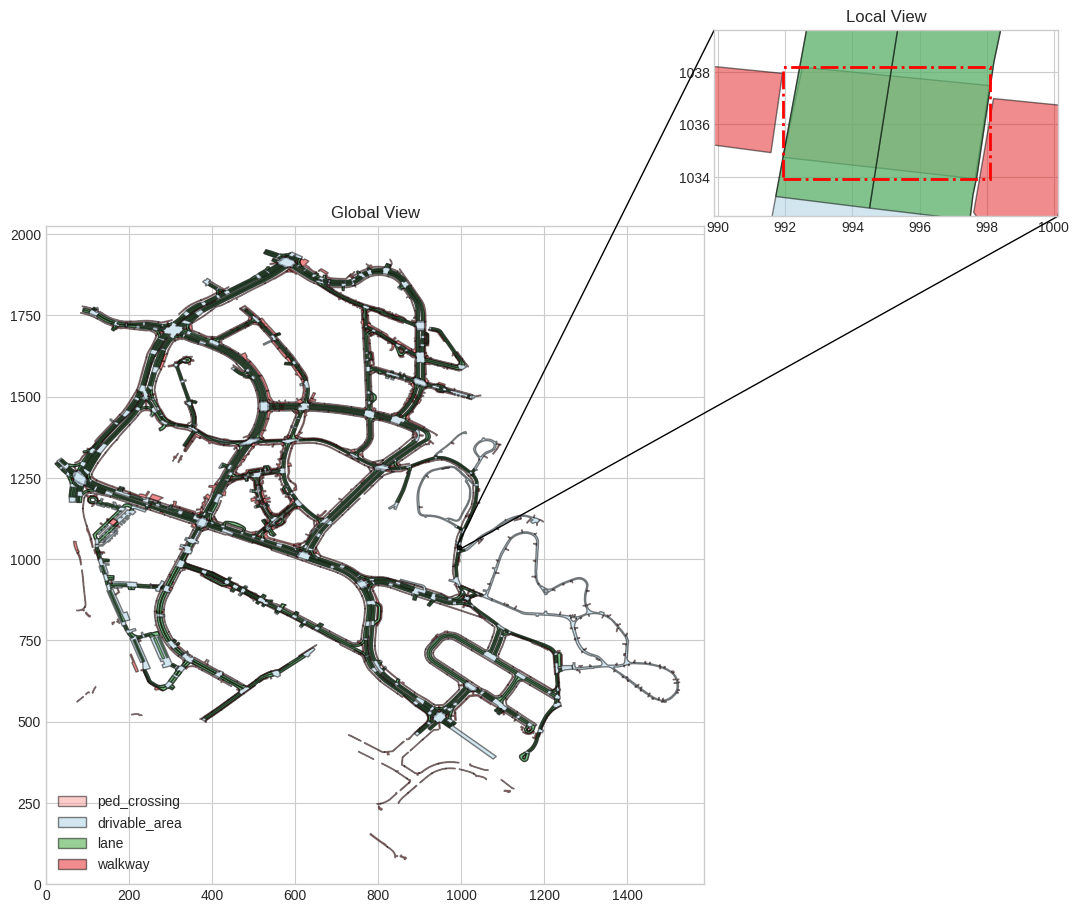

In [36]:
map_records = nusc_map.get_records_in_radius(1000,1000,100,layers,mode='intersect')
record = map_records['ped_crossing'][0]
print(record)
nusc_map.render_record('ped_crossing', record)

In [25]:
my_sample = nusc.sample[0]
print(my_sample['anns'])
print(my_sample)
my_annotation_token = my_sample['anns']
my_annotation_metadata =  nusc.get('sample_annotation', my_annotation_token)
my_annotation_metadata

['173a50411564442ab195e132472fde71', '5123ed5e450948ac8dc381772f2ae29a', 'acce0b7220754600b700257a1de1573d', '8d7cb5e96cae48c39ef4f9f75182013a', 'f64bfd3d4ddf46d7a366624605cb7e91', 'f9dba7f32ed34ee8adc92096af767868', '086e3f37a44e459987cde7a3ca273b5b', '3964235c58a745df8589b6a626c29985', '31a96b9503204a8688da75abcd4b56b2', 'b0284e14d17a444a8d0071bd1f03a0a2']
{'token': 'e93e98b63d3b40209056d129dc53ceee', 'timestamp': 1531883530449377, 'prev': '', 'next': '14d5adfe50bb4445bc3aa5fe607691a8', 'scene_token': '73030fb67d3c46cfb5e590168088ae39', 'data': {'RADAR_FRONT': 'bddd80ae33ec4e32b27fdb3c1160a30e', 'RADAR_FRONT_LEFT': '1a08aec0958e42ebb37d26612a2cfc57', 'RADAR_FRONT_RIGHT': '282fa8d7a3f34b68b56fb1e22e697668', 'RADAR_BACK_LEFT': '05fc4678025246f3adf8e9b8a0a0b13b', 'RADAR_BACK_RIGHT': '31b8099fb1c44c6381c3c71b335750bb', 'LIDAR_TOP': '3388933b59444c5db71fade0bbfef470', 'CAM_FRONT': '020d7b4f858147558106c504f7f31bef', 'CAM_FRONT_RIGHT': '16d39ff22a8545b0a4ee3236a0fe1c20', 'CAM_BACK_RIGHT': 

TypeError: unhashable type: 'list'

In [87]:
class ActionSegmenter:

    def __init__(self, straight_thresh=0.7, coast_thresh=0.1, stop_thresh=0.05, radius=100):
        #settings
        self.straight_thresh = straight_thresh # degree deadband for driving straight
        self.coast_thresh = coast_thresh # km/h deadband for driving at constant speed
        self.stop_thresh = stop_thresh #km/h thresh for being stopped
        self.radius = radius
        self.layers = nusc_map.non_geometric_layers

        #dynamic variables
        self.actions = []
        self.data = []

    def change_action(self, action, time):
        if not self.actions or self.actions[len(self.actions)-1]['label'] != action:
            self.actions.append({'label':action, 'time':time})
    
    def convert_utime_secs(self, data, start_utime):
        #convert to seconds
        for d in data:
            d['time'] = (d['utime'] - start_utime) * 1e-6
            del d['utime']
        return data

    '''
    extracts keyframes with their features from the core dataset
    also returns just the list of utimes, so that when extracting CAN data we can
    get the datapoints that best match in time
    '''
    def extract_core_data(self, scene_name):
        scene = self.find_scenes_by_name(scene_name)[0]
        print(scene)
        first_sample_token = scene['first_sample_token']
        
        sample = nusc.get('sample', first_sample_token)
        data = []
        utimes = []

        while True:
            # no data for now, just token to query annotations table with later
            data.append({'token':sample['token'], 'utime':sample['timestamp']})
            utimes.append(sample['timestamp'])

            next_token = sample['next']
            if next_token == '':
                break
            sample = nusc.get('sample', next_token)
        return data, utimes
    
    '''
    given the utimes of the keyframes, get the closest matching CAN data from each channel and add it to the data
    '''
    def extract_CAN_data(self, scene_name, utimes, data):
        pose_data = nusc_can.get_messages(scene_name, 'pose')
        steer_data = nusc_can.get_messages(scene_name, 'steeranglefeedback')
        i = 0
        j = 0
        for k,t in enumerate(utimes):
            while pose_data[i]['utime'] < t:
                if i == len(pose_data)-1:
                    break
                i+=1
            while steer_data[j]['utime'] < t:
                if j == len(steer_data)-1:
                    break
                j+=1

            # process the data before adding to core
            del pose_data[i]['utime']
            del steer_data[j]['utime']
            pose_data[i]['vel'] = pose_data[i]['vel'][0]
            steer_data[j]['steer'] = steer_data[j].pop('value')

            pose_data[i].update(steer_data[j])
            data[k].update(pose_data[i])
            i+=1
            j+=1
            
        #data = [{k: i[k] for k in feature_names} for i in raw_data]
        return data

    def query_map(self, keyframe):
        x = keyframe['pos'][0]
        y = keyframe['pos'][1]
        map_records = nusc_map.get_records_in_radius(x, y, self.radius, self.layers, mode='intersect')
        return map_records
    
    def segment(self, scene_name):
        self.actions = []
        core_data, utimes = self.extract_core_data(scene_name)
        data = self.extract_CAN_data(scene_name, utimes, core_data)
        data = self.convert_utime_secs(data, utimes[0])
        print("DATA - len:", len(data), "\ndata:", data)

        last_speed = data[0]['vel']

        for d in data:
            action = 'none'
            speed = d['vel']
            #acceleration = np.linalg.norm(np.array(d['accel'])) #TODO: dot with orientation
            acceleration = speed - last_speed
            steer = d['steer']
            time = d['time']

            if speed < self.stop_thresh:
                action = 'stop'
            else:
                if abs(steer) < self.straight_thresh:
                    if abs(acceleration) < self.coast_thresh:
                        action = 'drive straight'
                    elif acceleration > 0:
                        action = 'accelerate'
                    elif acceleration < 0:
                        action = 'decelerate'
                elif steer > 0:
                    action = 'turn left'
                elif steer < 0:
                    action = 'turn right'

            #update bookkeeping
            last_speed = speed

            self.change_action(action, time)

        self.data = data

        self.actions.append({'label':'END', 'time':data[len(data)-1]['time']})
        return self.actions

    def find_scenes_by_name(self, name):
        return [ i for i in nusc.scene if name in i['name'].lower() ]


In [88]:
# PLOTTING

def plot_actions(seg):
    # create action periods
    colors = {'stop':'red', 'drive straight':'blue', 'accelerate':'green', 'decelerate':'yellow', 'turn left':'orange', 'turn right':'magenta'}
    periods = []
    for i in range(len(seg.actions)-1):
        from_time = seg.actions[i]['time']
        to_time = seg.actions[i+1]['time']
        color = colors[seg.actions[i]['label']]
        periods.append((from_time, to_time, color))
    print(periods)

    xlabel = 'time'

    # Extract unique feature keys
    feature_keys = list(set().union(*(d.keys() for d in seg.data)))
    feature_keys.remove(xlabel)  # Remove 'timestamp' key
    feature_keys.remove('token')  # Remove 'token' key

    # Create a figure with subplots
    num_subplots = len(feature_keys)
    fig, axs = plt.subplots(num_subplots, 1, figsize=(8, 3 * num_subplots), sharex=True)

    # Plot each feature in a separate subplot
    for i, feature in enumerate(feature_keys):
        x = [d[xlabel] for d in seg.data]
        feature_values = [d[feature] for d in seg.data]
        
        if num_subplots == 1:
            ax = axs
        else:
            ax = axs[i]

        for start, end, color in periods:
            ax.axvspan(start, end, alpha=0.3, color=color)

        ax.plot(x, feature_values)
        ax.set_ylabel(feature)

    # Set x-axis label and title
    axs[-1].set_xlabel(xlabel)
    fig.suptitle('Feature Plots')

    plt.tight_layout()
    plt.show()

{'token': 'cc8c0bf57f984915a77078b10eb33198', 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2', 'nbr_samples': 39, 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5', 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0', 'name': 'scene-0061', 'description': 'Parked truck, construction, intersection, turn left, following a van'}
corelen: 39
core: [{'token': 'ca9a282c9e77460f8360f564131a8af5', 'utime': 1532402927647951}, {'token': '39586f9d59004284a7114a68825e8eec', 'utime': 1532402928147847}, {'token': '356d81f38dd9473ba590f39e266f54e5', 'utime': 1532402928698048}, {'token': 'e0845f5322254dafadbbed75aaa07969', 'utime': 1532402929197353}, {'token': 'c923fe08b2ff4e27975d2bf30934383b', 'utime': 1532402929697797}, {'token': 'f1e3d9d08f044c439ce86a2d6fcca57b', 'utime': 1532402930152601}, {'token': '4f545737bf3347fbbc9af60b0be9a963', 'utime': 1532402930648325}, {'token': '7626dde27d604ac28a0240bdd54eba7a', 'utime': 1532402931198511}, {'token': 'be99ffc878b24aca8956bbb4e0f97d0c', 'utim

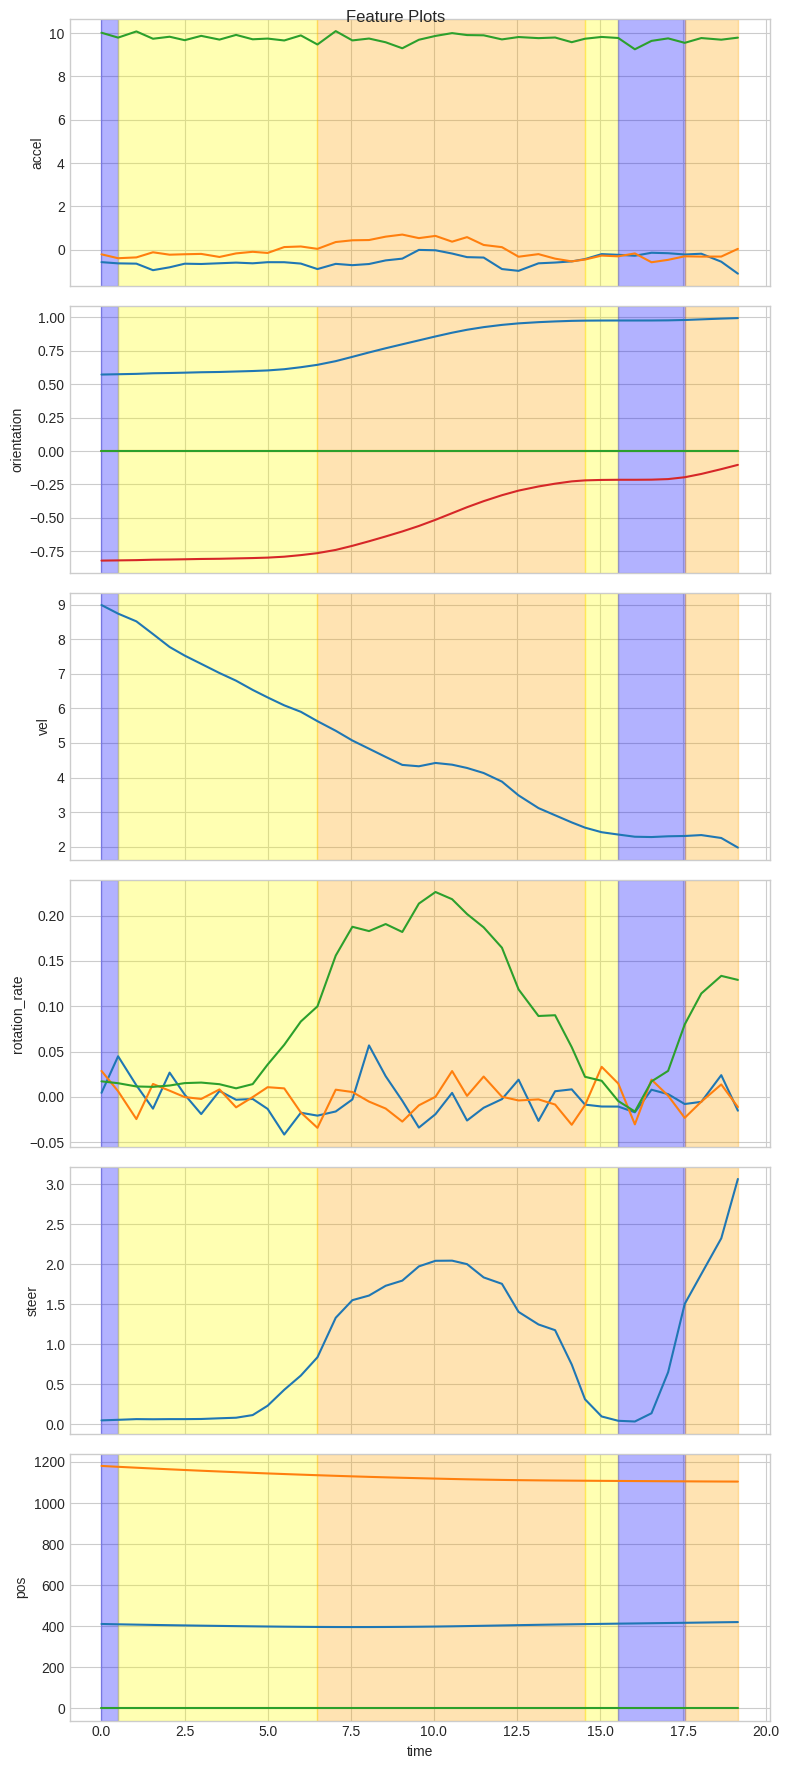

In [89]:
scene_name = 'scene-0061'
seg = ActionSegmenter()
actions = seg.segment(scene_name)
print(actions)
plot_actions(seg)